In [ ]:
# !pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

In [ ]:
# !pip3 install cma

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F21

rand_state = np.random.RandomState(1)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = rand_state.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 50
verbose = False

n_samples = 10000

max_cma_iter = 30

obj_func = F21(1)

In [ ]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')


# plot initial points provided to the CMA-ES and DoE, found by it, on the surface of the function
def plot_initial_found(func, samples, values, initial, found, result):
  fig, axs = plt.subplots(1, 2)
  fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
  plot(samples, values, ax=axs[0], outline=False) # plot surface
  axs[0].set_title('Initial individual for CMA-ES')
  plot(samples, values, ax=axs[1], outline=False)
  axs[1].set_title('DoE found by CMA-ES')
  plot(initial, ["blue"] * initial.shape[0], ax=axs[0], outline=False)
  plot(found, ["yellow"] * initial.shape[0], ax=axs[1], outline=False)
  plt.show()


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30):
  plt.suptitle("BO history", fontsize=8)
  plot(samples, values, ax=plt.gca(), outline=False) # plot surface
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=plt.gca(), marker='^', marker_size=marker_size)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      plt.scatter(x, y, color="magenta", s=marker_size)
      plt.annotate(str(i), h)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=plt.gca(), marker='s', marker_size=marker_size)

In [ ]:
def make_optimizer(obj_func, doe, random_state=None):
    space = RealSpace([lb, ub], random_state=random_state) * dim
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim,
        random_state=random_state
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1, 
        random_seed=random_state
    )
    
def regret_function(obj_func, doe_size, random_state):
    def func(X):
        X = X.clip(lb, ub)
        doe = np.split(X, doe_size)
        opt = make_optimizer(obj_func, doe, random_state=random_state)
        _, value, _ = opt.run()
        return value - obj_func.getfopt()
    return func

## Experiments

In [ ]:
def cma_es_experiment(obj_function, doe_size, individual0=None, sigma0 = ub / 3, random_state=1, cma_seed=1):
  if individual0 is None:
    individual0 = np.zeros(doe_size * dim) # initial individual
  
  # regret function with fixed random
  regret_func = regret_function(obj_function, doe_size, random_state=random_state)
  # run cma-es 
  doe_flattened, es = cma.fmin2(regret_func, individual0, sigma0, {'maxiter': max_cma_iter, 'seed': cma_seed})
  
  # split a vector into set of points
  doe = np.split(doe_flattened, doe_size)

  return doe, es

In [ ]:
def compute_regret(doe, n=10):
  regrets = []
  for seed in range(n):
    bo = make_optimizer(obj_func, doe, random_state=seed)
    xopt, yopt, _ = bo.run()
    regrets.append(yopt - obj_func.getfopt())
  return np.concatenate(regrets).mean()

## DoE of size 10

In [ ]:
doe_size = 10

### sigma = 5 / 2


#### DoE initialized with a random vector sampled from the uniform distribution


In [ ]:
random_state = 1
cma_seed = 1
rand = np.random.RandomState(10)
individual0 = rand.uniform(-5, 5, (dim * doe_size))
doe52, es52 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/2, random_state=random_state, cma_seed=cma_seed)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=1, Mon Oct 24 16:44:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 4.249132697410118e-03 1.0e+00 2.39e+00  2e+00  2e+00 1:38.0
    2     24 3.004019637913302e-04 1.1e+00 2.27e+00  2e+00  2e+00 3:09.8
    3     36 1.863244145845044e-03 1.1e+00 2.23e+00  2e+00  2e+00 4:43.0
    4     48 3.375232743223933e-03 1.2e+00 2.17e+00  2e+00  2e+00 6:13.5
    5     60 6.502553731024818e-06 1.2e+00 2.14e+00  2e+00  2e+00 7:44.0
    6     72 8.256463261133717e-04 1.2e+00 2.05e+00  2e+00  2e+00 9:19.7
    7     84 2.676125309619692e-05 1.2e+00 1.95e+00  2e+00  2e+00 10:51.0
    8     96 3.711623114391216e-03 1.2e+00 1.89e+00  2e+00  2e+00 12:18.9
    9    108 6.389054357427426e-04 1.3e+00 1.81e+00  2e+00  2e+00 13:47.4
   10    120 1.064762096234517e-02 1.3e+00 1.78e+00  2e+00  2e+00 15:20.0
   11    132 2.381184467736830e-05 1.3e+00 1.80e+00  2e+00  2e+00 16:54.6
   12    144 1.769557358451124e-0

In [ ]:
bo = make_optimizer(obj_func, doe52, 1)
xopt, yopt, _ = bo.run()

In [ ]:
compute_regret(doe52)

array([6.50255373e-06])

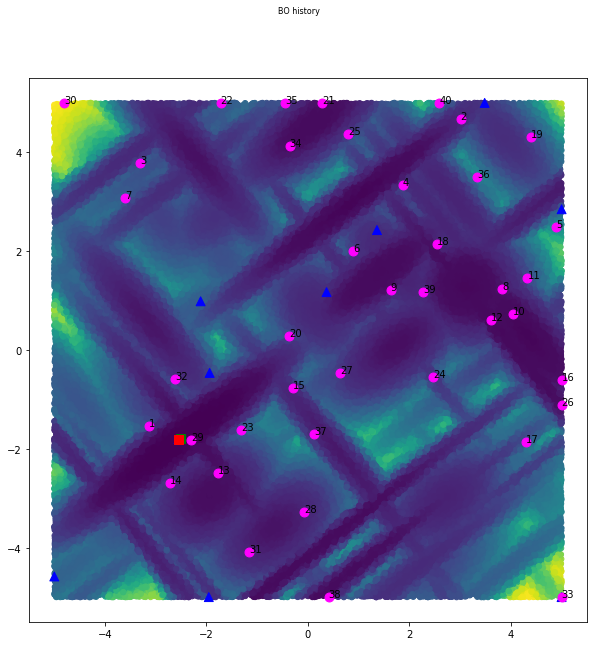

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

space = RealSpace([lb, ub], random_state=random_state) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
doe = np.array(doe52).clip(-5, 5)
result = {"initial_points": doe, "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

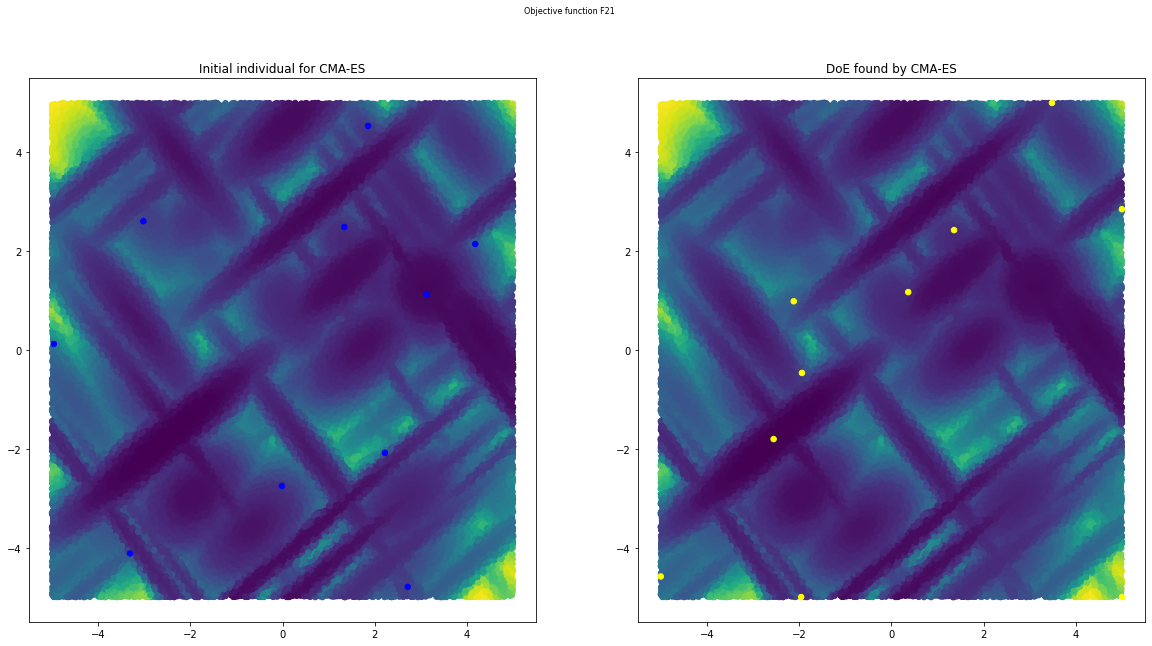

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10)

plot_initial_found(obj_func, samples, values, np.array(np.split(individual0, doe_size)), doe, xopt)

#### DoE initialized with lhs

In [ ]:
from pyDOE import lhs

In [ ]:
lhs_individual0 = np.concatenate(lhs(2, 10, random_state=1) * 10 - 5)
lhs_individual0

array([-2.85324411,  1.87811744, -0.60323253, -0.46118327, -1.81373979,
        2.67046751, -4.582978  , -4.27967551,  1.20445225, -3.69766743,
       -3.99988563, -2.90766141,  0.41919451, -1.65443927,  3.4173048 ,
        0.6852195 ,  2.02738759,  4.19810149,  4.14038694,  3.55868983])

In [ ]:
random_state = 1
cma_seed = 1
lhs_doe52, lhs_es52 = cma_es_experiment(obj_func, doe_size, individual0=lhs_individual0, sigma0=5/2, random_state=random_state, cma_seed=cma_seed)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=1, Mon Oct 24 15:28:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.018118102606991e-04 1.0e+00 2.36e+00  2e+00  2e+00 1:35.1
Invalid likelihood value. Increasing nugget...
    2     24 4.913232078322949e-04 1.1e+00 2.30e+00  2e+00  2e+00 3:11.2
    3     36 5.201821775457915e-04 1.1e+00 2.33e+00  2e+00  2e+00 4:46.0
Invalid likelihood value. Increasing nugget...
    4     48 5.907975395238907e-03 1.2e+00 2.27e+00  2e+00  2e+00 6:16.0
Invalid likelihood value. Increasing nugget...
    5     60 2.122684508947259e-04 1.2e+00 2.28e+00  2e+00  2e+00 7:46.5
    6     72 9.255519042570626e-02 1.2e+00 2.30e+00  2e+00  2e+00 9:12.9
    7     84 7.226064542464883e-05 1.3e+00 2.30e+00  2e+00  2e+00 10:36.5
    8     96 1.756438055622311e-05 1.3e+00 2.38e+00  2e+00  3e+00 12:08.7
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood v

In [ ]:
bo = make_optimizer(obj_func, lhs_doe52, random_state)
xopt, yopt, _ = bo.run()

In [ ]:
# Mean regret
regrets = []
for seed in range(10):
  bo = make_optimizer(obj_func, lhs_doe52, random_state=seed)
  xopt, yopt, _ = bo.run()
  regrets.append(yopt - obj_func.getfopt())
print(np.concatenate(regrets).mean())

0.5788042543211389


In [ ]:
with open('lhs_doe52.txt', 'w') as f:
  f.write(str(lhs_doe52))

with open('lhs_initial52.txt', 'w') as f:
  f.write(str(lhs(2, 10, random_state=1) * 10 - 5))

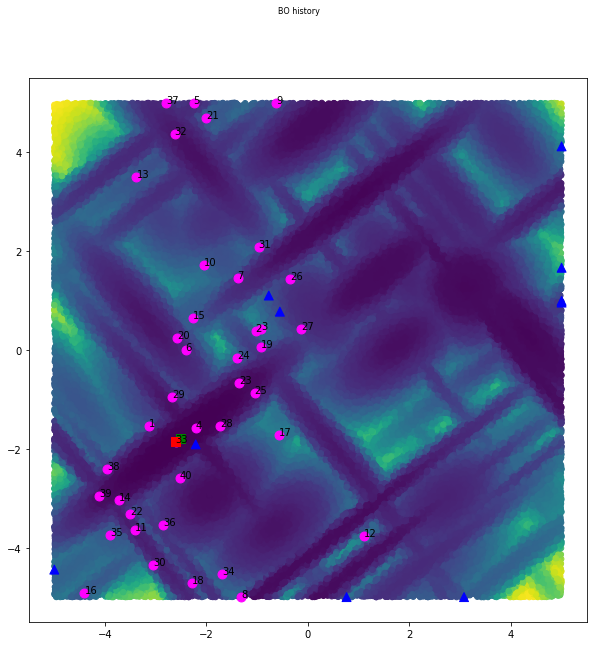

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

space = RealSpace([lb, ub], random_state=random_state) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
doe = np.array(lhs_doe52).clip(-5, 5)
result = {"initial_points": doe, "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

### sigma = 5 / 3

In [ ]:
random_state = 1
cma_seed = 1
rand = np.random.RandomState(10)
individual0 = rand.uniform(-5, 5, (dim * doe_size))
doe53, es53 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/3, random_state=random_state, cma_seed=cma_seed)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=1, Mon Oct 24 14:11:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 3.229305449394815e-04 1.0e+00 1.55e+00  2e+00  2e+00 1:35.2
    2     24 1.095126521400402e-02 1.1e+00 1.46e+00  1e+00  1e+00 3:04.4
    3     36 1.002866302286520e-04 1.1e+00 1.42e+00  1e+00  1e+00 4:37.2
Invalid likelihood value. Increasing nugget...
    4     48 3.979174529078477e-04 1.2e+00 1.40e+00  1e+00  1e+00 6:10.8
    5     60 2.095690429655406e-03 1.2e+00 1.38e+00  1e+00  1e+00 7:40.9
    6     72 2.075697409509303e-07 1.2e+00 1.35e+00  1e+00  1e+00 9:11.2
    7     84 5.034098500686923e-04 1.2e+00 1.34e+00  1e+00  1e+00 10:37.6
    8     96 9.191714943028728e-04 1.3e+00 1.36e+00  1e+00  1e+00 12:13.7
Invalid likelihood value. Increasing nugget...
    9    108 1.922587418690114e-04 1.3e+00 1.33e+00  1e+00  1e+00 13:48.5
   10    120 8.809545718975187e-04 1.3e+00 1.30e+00  1e+00  1e+00 15:19.9
   11    132 

In [ ]:
bo = make_optimizer(obj_func, doe53, random_state)
xopt, yopt, _ = bo.run()

In [ ]:
compute_regret(doe53)

0.913271293212572

In [ ]:
with open('doe53.txt', 'w') as f:
  f.write(str(doe53))

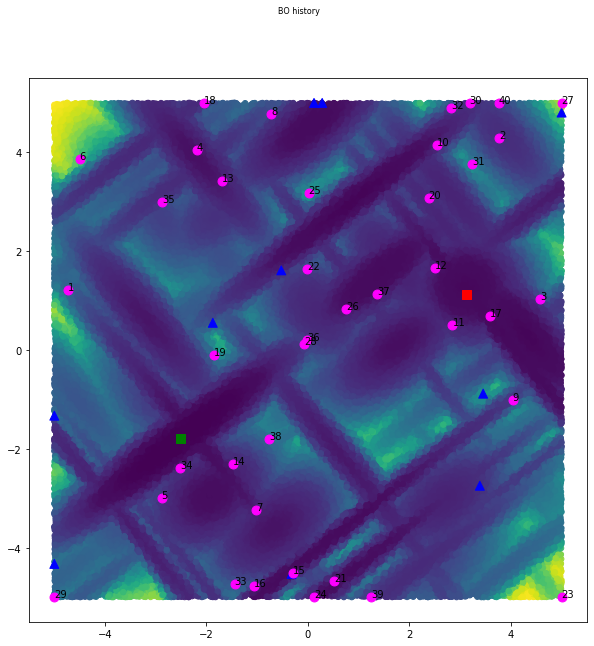

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

space = RealSpace([lb, ub], random_state=random_state) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
doe = np.array(doe53).clip(-5, 5)
result = {"initial_points": doe, "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

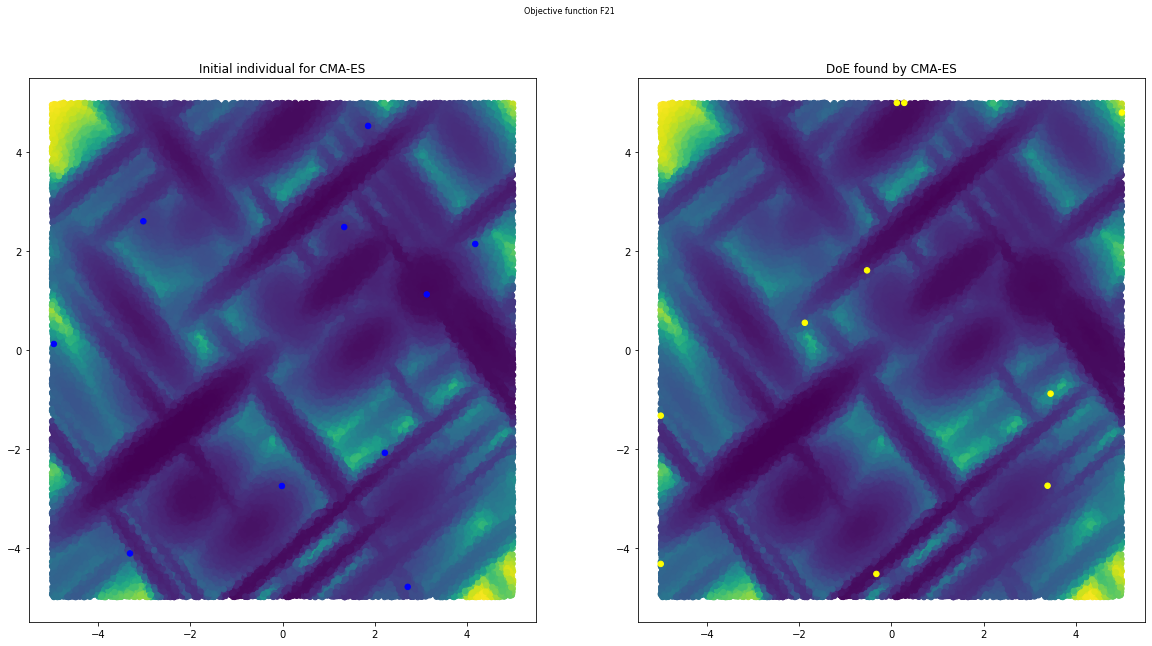

In [ ]:
plt.rcParams["figure.figsize"] = (20, 10)

plot_initial_found(obj_func, samples, values, np.array(np.split(individual0, doe_size)), doe, xopt)

### Use initial individual to train BO

In [ ]:
bo = make_optimizer(obj_func, np.array(np.split(individual0, doe_size)), 1)
xopt, yopt, _ = bo.run()

In [ ]:
yopt - obj_func.getfopt()

array([1.44741882])

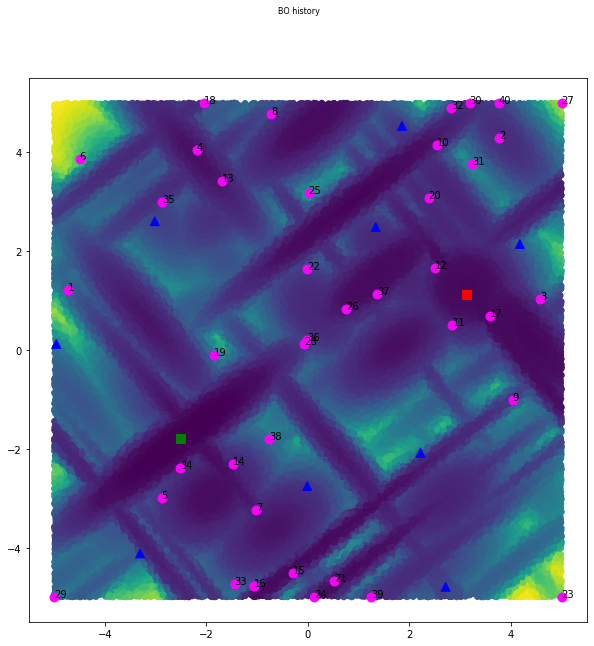

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)


doe = np.array(doe53).clip(-5, 5)
result = {"initial_points": np.array(np.split(individual0, doe_size)), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)